# AutoML Image Classification: With Rotation (Fashion MNIST)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/rotation.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    # random_state = RandomState(42)
    # x, y = load_digits(return_X_y=True)
    # y = y.astype(np.uint8)
    # return train_test_split(x, y, test_size=.25, random_state=random_state)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)
    return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    # err_img_node = Array(reshape=(8, 8))
    err_img_node = Array(reshape=(28, 28))

    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node
    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(GaussianNoise("mean", "std"))
    # err_img_node.addfilter(Clip("min_val", "max_val"))
    # return err_root_node

In [5]:
def get_err_params_list(data):
    angle_steps = np.linspace(0, 180, num=6)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list
    # min_val = np.amin(data)
    # max_val = np.amax(data)
    # std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    # err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    # return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*6
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        print(best_pipeline)
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=params["augment"], path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": False}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": False}],
        #     "use_clean_train_data": True
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": True}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base, "augment": True}],
        #     "use_clean_train_data": True
        # },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        # err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.988

182.92 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=2), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.45), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

183.79 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=2), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.45), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.984

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1ldav94f

  JVM stdout: /wrk/users/thalvari/tmp1ldav94f/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1ldav94f/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,13 days
H2O cluster name:,#853040058
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bd97 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.988

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpx5znmrsr

  JVM stdout: /wrk/users/thalvari/tmpx5znmrsr/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpx5znmrsr/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,14 days and 27 minutes
H2O cluster name:,#505478758
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a63f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.981

 17%|█▋        | 1/6 [17:26:00<87:10:01, 62760.29s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.934

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.708

180.53 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GaussianNB(DecisionTreeClassifier(GradientBoostingClassifier(GradientBoostingClassifier(SGDClassifier(input_matrix, alpha=0.01, eta0=1.0, fit_intercept=False, l1_ratio=0.0, learning_rate=constant, loss=modified_huber, penalty=elasticnet, power_t=1.0), learning_rate=0.1, max_depth=7, max_features=0.4, min_samples_leaf=7, min_samples_split=12, n_estimators=100, subsample=0.6500000000000001), learning_rate=0.01, max_depth=10, max_features=0.55, min_samples_leaf=17, min_samples_split=8, n_estimators=100, subsample=0.05), criterion=gini, max_depth=7, min_samples_leaf=17, min_samples_split=9)), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.946

183.21 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=2), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.45), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.767

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpl11eb8uj

  JVM stdout: /wrk/users/thalvari/tmpl11eb8uj/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpl11eb8uj/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,"14 days, 15 hours and 11 minutes"
H2O cluster name:,#710036023
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9483 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.961

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp5arrzfel

  JVM stdout: /wrk/users/thalvari/tmp5arrzfel/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp5arrzfel/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,"14 days, 17 hours and 50 minutes"
H2O cluster name:,#629296903
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aae7 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.685

 33%|███▎      | 2/6 [34:49:23<69:40:52, 62713.05s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.887

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.451

182.65 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=2, min_samples_split=4, n_estimators=100)), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.934

183.40 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=2), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.45), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.506

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpgjmqyyhz

  JVM stdout: /wrk/users/thalvari/tmpgjmqyyhz/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpgjmqyyhz/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,15 days
H2O cluster name:,#646273499
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b67c closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.918

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpkryn9de_

  JVM stdout: /wrk/users/thalvari/tmpkryn9de_/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpkryn9de_/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,15 days
H2O cluster name:,#254239491
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9388 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.416

 50%|█████     | 3/6 [52:21:32<52:21:53, 62837.92s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.833

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.37

200.80 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.8500000000000001, min_samples_leaf=3, min_samples_split=15, n_estimators=100)), n_neighbors=6, p=1, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.891

182.30 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=2), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.45), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.409

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpepv2upe2

  JVM stdout: /wrk/users/thalvari/tmpepv2upe2/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpepv2upe2/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,16 days
H2O cluster name:,#445437223
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_917f closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.907

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp63o5kr90

  JVM stdout: /wrk/users/thalvari/tmp63o5kr90/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp63o5kr90/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,16 days
H2O cluster name:,#431312489
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_90ab closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.358

 67%|██████▋   | 4/6 [69:59:00<35:00:42, 63021.08s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.716

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.307

184.26 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(XGBClassifier(input_matrix, learning_rate=0.1, max_depth=9, min_child_weight=8, n_estimators=100, nthread=1, subsample=0.4)), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.852

182.90 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=2), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.45), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.335

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmptipku427

  JVM stdout: /wrk/users/thalvari/tmptipku427/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmptipku427/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,16 days
H2O cluster name:,#452097142
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a2b2 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.875

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpbpsg5baf

  JVM stdout: /wrk/users/thalvari/tmpbpsg5baf/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpbpsg5baf/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,16 days
H2O cluster name:,#514843212
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b585 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.28

 83%|████████▎ | 5/6 [87:17:25<17:26:46, 62806.18s/it]

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.739

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.284

181.45 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MaxAbsScaler(KNeighborsClassifier(MaxAbsScaler(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.5, min_samples_leaf=3, min_samples_split=7, n_estimators=100)), n_neighbors=23, p=1, weights=distance)), n_neighbors=2, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.852

185.85 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(LinearSVC(DecisionTreeClassifier(PCA(input_matrix, iterated_power=6, svd_solver=randomized), criterion=gini, max_depth=7, min_samples_leaf=10, min_samples_split=2), C=0.5, dual=True, loss=squared_hinge, penalty=l2, tol=0.01), learning_rate=0.001, max_depth=8, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=13, n_estimators=100, subsample=0.45), n_neighbors=4, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.362

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpi1r7zfoz

  JVM stdout: /wrk/users/thalvari/tmpi1r7zfoz/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpi1r7zfoz/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,17 days
H2O cluster name:,#849119486
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_82df closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.856

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpg_6bvok3

  JVM stdout: /wrk/users/thalvari/tmpg_6bvok3/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpg_6bvok3/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,17 days
H2O cluster name:,#507471570
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b6c2 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.268

100%|██████████| 6/6 [104:46:11<00:00, 62842.09s/it]  

100%|██████████| 6/6 [104:46:11<00:00, 62861.91s/it]

'AutoKeras #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.18,0.001,10828.6
36,0.934,0.994,0.309,0.001,10806.7
72,0.887,0.986,0.23,0.001,10838
108,0.833,0.989,0.297,0.001,10809.8
144,0.716,0.97,0.417,0.001,10821.9
180,0.739,0.975,0.267,0.001,10832.4


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)",ReLU

'AutoKerasClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,0.999,0.18,0.001,10805.5
36,0.708,0.999,0.309,0.001,10825.6
72,0.451,0.999,0.23,0.001,10836.5
108,0.37,0.999,0.297,0.001,10834.9
144,0.307,0.999,0.417,0.001,10823.7
180,0.284,0.999,0.267,0.001,10825.4


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)","Con

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.988,1,0.18,0.001,9549.02
36,0.961,1,0.309,0.001,9549.71
72,0.918,1,0.23,0.001,9917.14
108,0.907,1,0.297,0.001,9247.22
144,0.875,1,0.417,0.001,9053.8
180,0.856,1,0.267,0.001,9656.88


'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.18,0.001,9546.3
36,0.685,1,0.309,0.001,9556.85
72,0.416,1,0.23,0.001,9556.39
108,0.358,1,0.297,0.001,9548.82
144,0.28,1,0.417,0.001,9550.85
180,0.268,1,0.267,0.001,9553.85


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6
0,StackedEnsemble_BestOfFamily_AutoML_20191121_130023,DeepLearning_grid_1_AutoML_20191121_130023_model_26,GBM_grid_1_AutoML_20191121_130023_model_145,XGBoost_grid_1_AutoML_20191121_130023_model_398,DRF_1_AutoML_20191121_130023,XRT_1_AutoML_20191121_130023,GLM_grid_1_AutoML_20191121_130023_model_1
36,StackedEnsemble_BestOfFamily_AutoML_20191122_062336,DeepLearning_grid_1_AutoML_20191122_062336_model_29,GBM_grid_1_AutoML_20191122_062336_model_145,XGBoost_grid_1_AutoML_20191122_062336_model_398,DRF_1_AutoML_20191122_062336,XRT_1_AutoML_20191122_062336,GLM_grid_1_AutoML_20191122_062336_model_1
72,StackedEnsemble_BestOfFamily_AutoML_20191122_235547,DeepLearning_grid_1_AutoML_20191122_235547_model_38,GBM_grid_1_AutoML_20191122_235547_model_145,XGBoost_grid_1_AutoML_20191122_235547_model_398,DRF_1_AutoML_20191122_235547,XRT_1_AutoML_20191122_235547,GLM_grid_1_AutoML_20191122_235547_model_1
108,StackedEnsemble_BestOfFamily_AutoML_20191123_173323,DeepLearning_grid_1_AutoML_20191123_173323_model_55,GBM_grid_1_AutoML_20191123_173323_model_145,XGBoost_grid_1_AutoML_20191123_173323_model_398,DRF_1_AutoML_20191123_173323,XRT_1_AutoML_20191123_173323,GLM_grid_1_AutoML_20191123_173323_model_1
144,StackedEnsemble_BestOfFamily_AutoML_20191124_105143,DeepLearning_grid_1_AutoML_20191124_105143_model_26,GBM_grid_1_AutoML_20191124_105143_model_145,XGBoost_grid_1_AutoML_20191124_105143_model_398,DRF_1_AutoML_20191124_105143,XRT_1_AutoML_20191124_105143,GLM_grid_1_AutoML_20191124_105143_model_1
180,StackedEnsemble_BestOfFamily_AutoML_20191125_042027,DeepLearning_grid_1_AutoML_20191125_042027_model_60,GBM_grid_1_AutoML_20191125_042027_model_145,XGBoost_grid_1_AutoML_20191125_042027_model_398,DRF_1_AutoML_20191125_042027,XRT_1_AutoML_20191125_042027,GLM_grid_1_AutoML_20191125_042027_model_1


'TPOTClassifier #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.18,0.001,10989.5
36,0.946,1,0.309,0.001,10858.1
72,0.934,1,0.23,0.001,10964.1
108,0.891,1,0.297,0.001,12056.1
144,0.852,1,0.417,0.001,11066.1
180,0.852,1,0.267,0.001,10894.1


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5
0,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.45, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')",nan
36,"StackingEstimator(estimator=SGDClassifier(alpha=0.01, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=False, l1_ratio=0.0, learning_rate='constant', loss='modified_huber', max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='elasticnet', power_t=1.0, random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=7, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=7, min_samples_split=12, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.6500000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.01, loss='deviance', max_depth=10, max_features=0.55, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=17, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.05, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=17, min_samples_split=9, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=GaussianNB(priors=None, var_smoothing=1e-09))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
72,"StackingEstimator(estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=2, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False))","MinMaxScaler(copy=True, feature_range=(0, 1))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')",nan,nan,nan
108,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features=0.8500000000000001

'TPOTClassifierClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.984,1,0.18,0.001,11040
36,0.767,1,0.309,0.001,11005.2
72,0.506,1,0.23,0.001,11016.4
108,0.409,1,0.297,0.001,10950.8
144,0.335,1,0.417,0.001,10986.4
180,0.362,1,0.267,0.001,11163.8


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4
0,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.45, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
36,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.45, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
72,"PCA(copy=True, iterated_power=6, n_components=None, random_state=42, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=42, splitter='best'))","StackingEstimator(estimator=LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=0.01, verbose=0))","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.001, loss='deviance', max_depth=8, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.45, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
108,"PCA(copy=True, iterated_power=6, n_components=None, random_state=4

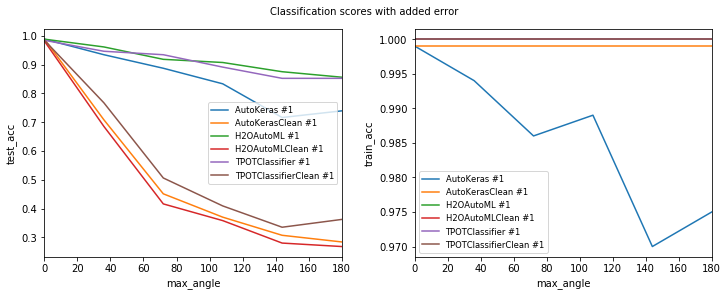

In [11]:
print_results_by_model(df,
    ["train_labels", "test_labels"],
    # ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    err_param_name="max_angle",
    # err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)